In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer, load_digits
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score

plt.style.use('seaborn')

In [2]:
def feature_normalize(X):
    mu = X.mean(axis=0)
    sigma = X.std(axis=0)
    X_norm = (X - mu) / sigma
    return X_norm, mu, sigma


def sigmoid(z):
    return 1 / (1 + np.e**-z)


def hypothesis(X, theta):
    h = sigmoid(X @ theta)
    return h


def cost(X, y, theta, regularize=False, lambda_=None):
    m = X.shape[0]
    h = hypothesis(X, theta)
    J = 1 / m * (-y@np.log(h) - (1-y)@np.log(1-h))
    if regularize:
        J += lambda_ * (theta[1:] ** 2).sum()
    return J


def gradient_descent(X, y, theta, alpha, n_iter, regularize=False, lambda_=None):
    m = X.shape[0]
    J_history = []
    theta_history = []
    for _ in range(n_iter):
        h = hypothesis(X, theta)
        gradient = 1 / m * X.T @ (h - y)
        if regularize:
            gradient += lambda_ / m * np.hstack([np.zeros(1), theta[1:]])
        theta = theta - alpha*gradient
        theta_history.append(theta)
        J = cost(X, y, theta, regularize=regularize, lambda_=lambda_)
        J_history.append(J)
    theta_history = np.array(theta_history)
    return theta, theta_history, J_history


def predict(X, theta, threshold=0.5):
    h = hypothesis(X, theta)
    pred = (h >= threshold).astype(int)
    return pred


def FPR(y_true, y_pred):
    conf = confusion_matrix(y_true, y_pred)
    return conf[0, 1] / conf.sum(axis=1)[0]


def predict_one_vs_all(X, Theta):
    return np.argmax(X @ Theta.T, axis=1)

### Part 1: Binary Classification

In [3]:
# Load data
cancer = load_breast_cancer()
X = cancer.data[:, :2]
y = cancer.target

# Scale features
X, mu, sigma = feature_normalize(X)

# Add intercept term to X
m, n = X.shape
intercept = np.ones((m, 1))
X = np.hstack([intercept, X])

# Initialize theta
theta = np.zeros(n + 1)

alpha = 1
n_iter = 200
lambda_ = 0.0001

# Run gradient descent
theta, theta_history, J_history = gradient_descent(X, y, theta, alpha, n_iter,
                                                   True, lambda_)

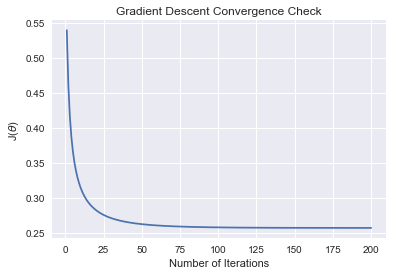

In [4]:
plt.plot(range(1, n_iter+1), J_history)
plt.xlabel('Number of Iterations')
plt.ylabel(r'J($\theta$)')
plt.title('Gradient Descent Convergence Check')
plt.show()

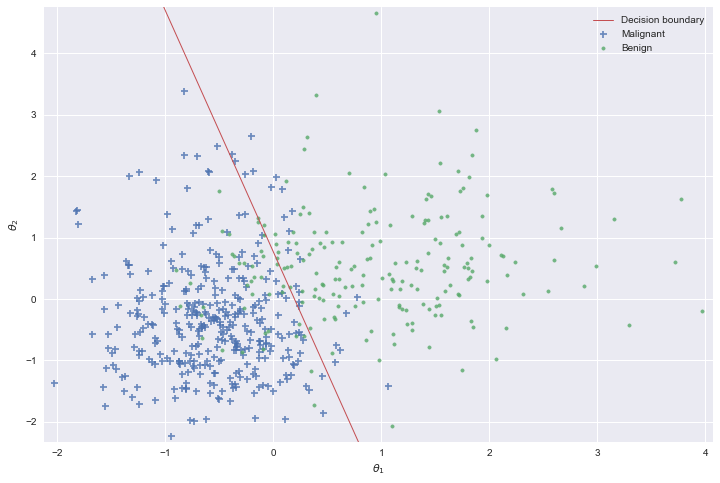

In [5]:
# Calculate decision boundary line
xs = np.array([X[:, 1].min(), X[:, 1].max()])
ys = -(theta[0] + theta[1]*xs) / theta[2]

# Plot data with decision boundary
plt.figure(figsize=(12, 8))
plt.scatter(X[np.where(y==1)[0], 1], X[np.where(y==1)[0], 2],
            marker='+', alpha=0.8, label='Malignant')
plt.scatter(X[np.where(y==0)[0], 1], X[np.where(y==0)[0], 2],
            marker='.', alpha=0.8, label='Benign')
plt.plot(xs, ys, c='C2', linewidth=1, label='Decision boundary')
plt.xlim(X[:, 1].min()-0.1, X[:, 1].max()+0.1)
plt.ylim(X[:, 2].min()-0.1, X[:, 2].max()+0.1)
plt.xlabel(r'$\theta_1$')
plt.ylabel(r'$\theta_2$')
plt.legend()
plt.show()

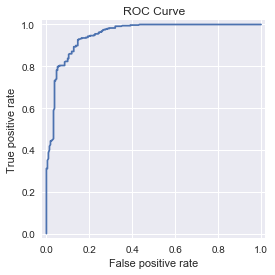

Accuracy: 0.8910


In [6]:
thresholds = np.linspace(0, 1, 1000)
y_preds = [predict(X, theta, threshold) for threshold in thresholds]
FPRs = [FPR(y, y_pred) for y_pred in y_preds]
TPRs = [recall_score(y, y_pred) for y_pred in y_preds]

# Plot ROC curve
plt.figure(figsize=(4, 4))
plt.plot(FPRs, TPRs)
plt.margins(0.02)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve')
plt.show()

y_pred = predict(X, theta)
print('Accuracy: {:.4f}'.format(accuracy_score(y, y_pred)))

### Part 2: One-vs-all Classification

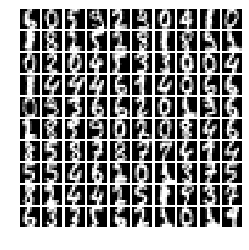

Accuracy: 0.9789


In [7]:
# Load data
digits = load_digits()
X = digits.data
y = digits.target

# Randomly select 100 digits to display
np.random.seed(7)
samples = np.random.choice(range(X.shape[0]), size=100, replace=False)
plt.figure(figsize=(4, 4))
plt.gray()
for i in range(len(samples)):
    plt.subplot(10, 10, i+1)
    plt.imshow(X[samples[i]].reshape((8, 8)))
    plt.axis('off')
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

# Add intercept term to X
m, n = X.shape
intercept = np.ones((m, 1))
X = np.hstack([intercept, X])

# Initialize Theta
k = len(np.unique(y))
Theta = np.zeros((k, n + 1))

# Train one classifier for each class
alpha = 0.03
n_iter = 600
lambda_ = 0.0001
for i in range(Theta.shape[0]):
    Theta[i, :] = gradient_descent(X, (y==i).astype(int), Theta[i, :],
                                   alpha, n_iter, True, lambda_)[0]

y_pred = predict_one_vs_all(X, Theta)
print('Accuracy: {:.4f}'.format(accuracy_score(y, y_pred)))